# Image Classification with Convolutional Neural Networks

In this article we'll build a simple convolutional neural network in PyTorch and train it to recognize handwritten digits using the MNIST dataset. Training a classifier on the MNIST dataset can be regarded as the hello world of image recognition.

> Dataset: MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels, and centered to reduce preprocessing and get started quicker. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms


# Choose the appropriate device based on availability (CUDA or CPU)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # For Windows
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # For M1 Mac
print(f"Using device: {device}")


Using device: mps


In [2]:
n_epochs = 3
batch_size_train = 32
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.9
log_interval = 100

torch.manual_seed(42)

## Create train and test data

We also need DataLoaders for the dataset. This is where TorchVision comes into play. Let's use load the MNIST dataset directly. We'll use a batch_size of 64 for training and size 1000 for testing on this dataset. The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset, so we'll take them as a given here. TorchVision offers a lot of handy transformations, such as cropping or normalization.

In [3]:
# download and transform train dataset

# The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset, we'll take them as a given here.
train_loader = torch.utils.data.DataLoader(
                              datasets.MNIST('MNIST', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ])),
                              batch_size=batch_size_train, 
                              shuffle=True)

test_loader = torch.utils.data.DataLoader(
                              datasets.MNIST('MNIST', train=False, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                              ])),
                              batch_size=batch_size_test, 
                              shuffle=True)

In [4]:
# Generating some samples from the dataloader
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

# Shape of the sample
"""
Interpreting the data - 
    64 : size of the train batch
    1 : Number of channels. Its 1 since its a gray scale image
    28, 28 : Resolution of the image

"""
example_data.shape

torch.Size([32, 1, 28, 28])

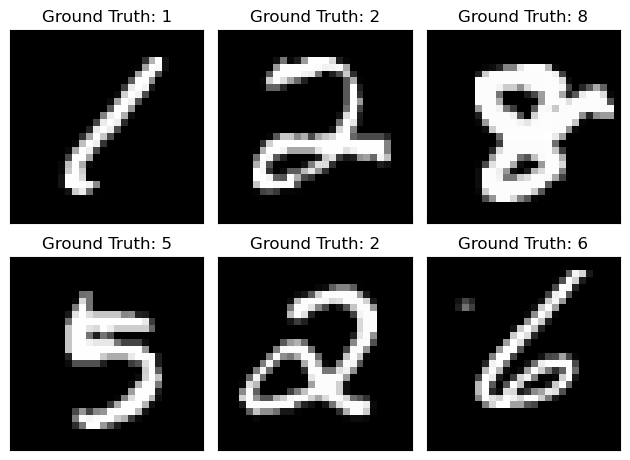

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)  
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()
plt.show()


## Define a neural network

Now we're ready to define our neural network. In this case, we'll create a network that consists of 3 fully-connected layers:

- An input layer that receives an input value for each feature (in this case, the four penguin measurements) and applies a ReLU activation function.
- A hidden layer that receives ten inputs and applies a ReLU activation function.
- An output layer that generates a non-negative numeric output for each class (which a loss function will translate into classification probabilities for each of the possible target labels).

> Additional note: Even though we are using dropout, we are still calling it a fully connected layet. The presence or absence of dropout doesn't affect the fundamental definition of a fully connected layer. Dropout modifies the training process by temporarily disabling connections, promoting robustness.
> Here's an analogy: Imagine a fully connected layer as a densely woven net. Dropout is like temporarily removing some threads from the net during training. The overall structure remains a net, but it becomes less prone to getting stuck on specific connections. Therefore, you can absolutely call a layer with dropout a fully connected layer. The term "fully connected" refers to the overall architecture, while dropout addresses a specific training technique for regularisation.

In [6]:
# Define the CNN model
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # input is 28x28x1
        # conv1(kernel=5, filters=10) 28x28x10 -> 24x24x10
        # max_pool(kernel=2) 24x24x10 -> 12x12x10
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        
        # conv2(kernel=5, filters=20) 12x12x20 -> 8x8x20
        # max_pool(kernel=2) 8x8x20 -> 4x4x20
        x = F.relu(F.max_pool2d(self.dropout(self.conv2(x)), 2))
        
        # flatten 4x4x20 = 320
        x = x.view(-1, 320)
        
        # 320 -> 50
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        # 50 -> 10
        x = self.fc2(x)
        
        # transform to logits
        return F.log_softmax(x, dim=1)


## Train the model

In [7]:
# Create a model instance from the network
clf = CNNClassifier().to(device)

# Define Kaiming Normal weight initialization function
def weights_init(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        m.bias.data.fill_(0.01)

# Apply weight initialization to the model
clf.apply(weights_init)

# Define optimizer and loss function
opt = optim.SGD(clf.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

# Empty list to store loss and accuracy for each epoch
acc_history= []

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs)]


# Train the model
def train(epoch):
    clf.train() # Set model in training mode

    for batch_id, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)

        # Forward pass
        opt.zero_grad()
        output = clf(data)
        loss = criterion(output, label)
        loss.backward()
        train_losses.append(loss.item())
        opt.step()

        if batch_idx % log_interval == 0:
          print('Training Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch+1, batch_id * len(data), len(train_loader.dataset),
            100. * batch_id / len(train_loader), loss.item()))
          
          train_counter.append((batch_id*batch_size_train) + ((epoch)*len(train_loader.dataset)))
          
def eval():
    clf.eval() # set model in inference mode (need this to avoid backpropagation)
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = clf(data)
            test_loss += criterion(output, label)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(label.data.view_as(pred)).sum()
    
    # Calculate the average test loss
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss.item())
    
    # Calculate accuracy
    accuracy = 100. * correct / len(test_loader.dataset)
    acc_history.append(accuracy)

    # Print test loss and accuracy for each epoch    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [8]:
for epoch in range(n_epochs):
    train(epoch)
    eval()

Training Epoch: 1 [0/60000 (0%)]	Loss: 9.031775
Training Epoch: 1 [32/60000 (0%)]	Loss: 6.298464
Training Epoch: 1 [64/60000 (0%)]	Loss: 3.922478
Training Epoch: 1 [96/60000 (0%)]	Loss: 2.450428
Training Epoch: 1 [128/60000 (0%)]	Loss: 2.609453
Training Epoch: 1 [160/60000 (0%)]	Loss: 2.245797
Training Epoch: 1 [192/60000 (0%)]	Loss: 2.135039
Training Epoch: 1 [224/60000 (0%)]	Loss: 2.381904
Training Epoch: 1 [256/60000 (0%)]	Loss: 2.346053
Training Epoch: 1 [288/60000 (0%)]	Loss: 2.177135
Training Epoch: 1 [320/60000 (1%)]	Loss: 2.113847
Training Epoch: 1 [352/60000 (1%)]	Loss: 2.159397
Training Epoch: 1 [384/60000 (1%)]	Loss: 2.286891
Training Epoch: 1 [416/60000 (1%)]	Loss: 2.228845
Training Epoch: 1 [448/60000 (1%)]	Loss: 2.120340
Training Epoch: 1 [480/60000 (1%)]	Loss: 2.191727
Training Epoch: 1 [512/60000 (1%)]	Loss: 2.072265
Training Epoch: 1 [544/60000 (1%)]	Loss: 2.248223
Training Epoch: 1 [576/60000 (1%)]	Loss: 2.446813
Training Epoch: 1 [608/60000 (1%)]	Loss: 2.221024
Train

## Plot training and test losses

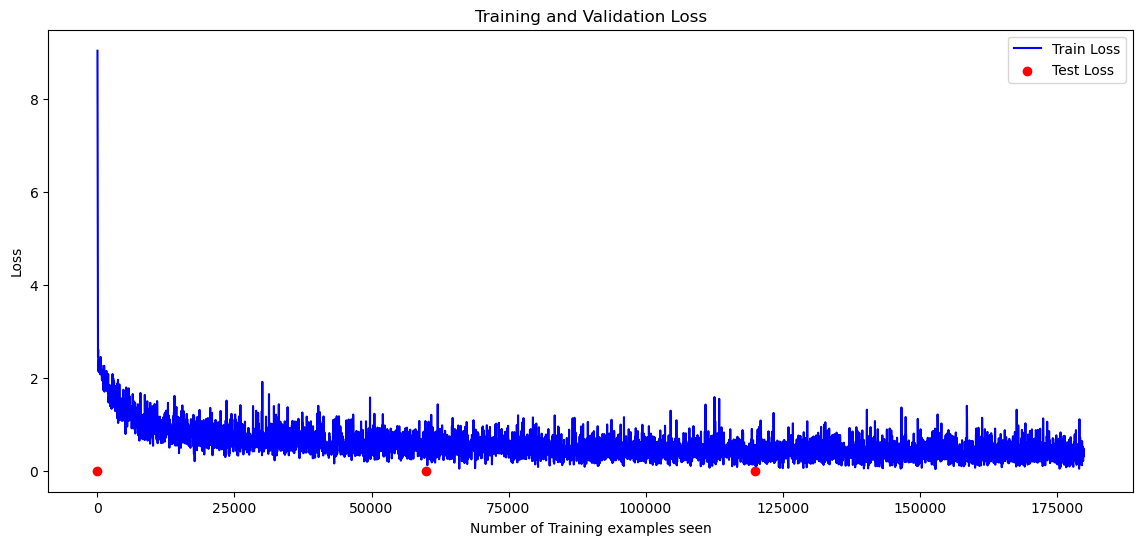

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Matplotlib works with NumPy arrays, not tensors on the GPU (MPS in our case). Convert to numpy arrays
test_counter_cpu = np.array(test_counter)
test_losses_cpu = np.array(test_losses)

# Create the plot
plt.figure(figsize=(14, 6))

# Plot training and test loss curves
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')

# Add labels and title
plt.title('Training and Validation Loss')
plt.xlabel('Number of Training examples seen')
plt.ylabel('Loss')

plt.show()



## Make prediction on test images

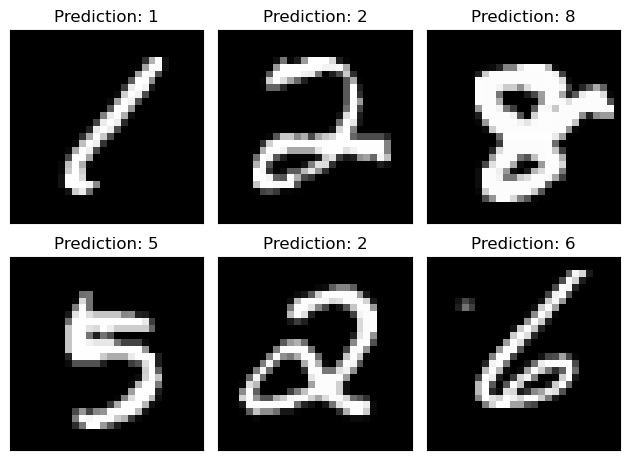

In [11]:
# Sample predictions

with torch.no_grad():
  ex = example_data.to(device)
  output = clf(ex)


for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()
plt.show()